### XGBoost for predicting which item sessions with NO numerical references will click

In [1]:
import pandas as pd
import os
import data
import numpy as np

In [2]:
path = '/Users/danmontesi/Desktop/recsys2019'
os.chdir(path)
print(os.getcwd())

/Users/danmontesi/Desktop/recsys2019


In [6]:
import xgboost as xgb
#Avoid kernel crash
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from utils.check_folder import check_folder
from tqdm.auto import tqdm  # for notebooks
tqdm.pandas()

## Build the dataset

In [27]:
train_df = data.train_df("full")

/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [30]:
#Keep only sessions which belongs to the cluster with no numeric references
no_num_ref_sessions = list(set( train_df.loc[data.target_indices("local", cluster="cluster_sessions_no_numerical_reference")]["session_id"]))
train_df = train_df[train_df["session_id"].isin(no_num_ref_sessions)]


In [32]:
train_df.to_csv("train.csv")
#And put on data_classification on pycharm, ... after a while (20m) load here:

In [91]:
dataset = data.classification_train_df("small", "cluster_sessions_no_numerical_reference")
dataset = dataset.set_index([ dataset.index ,"user_id", "session_id"])

In [211]:
dataset.head(10)

,,,label,times_impression_appeared,time_elapsed_from_last_time_impression_appeared,impression_position,steps_from_last_time_impression_appeared,price,price_position,item_id,popularity,other change of sort order session,...,Terrace (Hotel),Theme Hotel,Towels,Very Good Rating_y,Volleyball,Washing Machine,Water Slide,Wheelchair Accessible,WiFi (Public Areas),WiFi (Rooms)
,user_id,session_id,,,,,,,,,,,,,,,,,,,,,
0,00RL8Z82B2Z1,aff3928535f48,0,0,-1,1,0,162,22,55109,917942.0,0,...,0,0,0,1,1,0,0,0,1,1
1,00RL8Z82B2Z1,aff3928535f48,0,0,-1,2,0,25,1,129343,657696.0,0,...,0,0,0,0,0,1,0,0,0,1
2,00RL8Z82B2Z1,aff3928535f48,0,0,-1,3,0,150,21,54824,643694.0,0,...,0,0,0,0,0,1,0,1,1,1
3,00RL8Z82B2Z1,aff3928535f48,0,0,-1,4,0,143,18,2297972,173694.0,0,...,0,0,0,0,0,0,0,1,1,1
4,00RL8Z82B2Z1,aff3928535f48,0,0,-1,5,0,101,8,109014,302652.0,0,...,1,0,1,1,0,1,0,0,1,1
5,00RL8Z82B2Z1,aff3928535f48,1,0,-1,6,0,49,3,1257342,695414.0,0,...,0,0,0,0,0,1,0,0,1,0
6,00RL8Z82B2Z1,aff3928535f48,0,0,-1,7,0,118,11,1031578,186876.0,0,...,1,0,0,0,0,1,0,1,1,1
7,00RL8Z82B2Z1,aff3928535f48,0,0,-1,8,0,131,15,109018,399890.0,0,...,1,0,0,1,0,0,0,0,1,1
8,00RL8Z82B2Z1,aff3928535f48,0,0,-1,9,0,18,0,1332971,505546.0,0,...,1,0,0,0,0,1,0,1,1,1


## Split the data

In [142]:
threshold_test_train = 1515
X_train, y_train = dataset.iloc[:, list(range(1, dataset.shape[1]))][threshold_test_train:], list(dataset.iloc[:,0][threshold_test_train:])
X_test, y_test = dataset.iloc[:, list(range(1, dataset.shape[1]))][:threshold_test_train], list(dataset.iloc[:,0][:threshold_test_train])

In [210]:
X_train.head(30)

,,,times_impression_appeared,time_elapsed_from_last_time_impression_appeared,impression_position,steps_from_last_time_impression_appeared,price,price_position,item_id,popularity,other change of sort order session,other clickout item session,...,Terrace (Hotel),Theme Hotel,Towels,Very Good Rating_y,Volleyball,Washing Machine,Water Slide,Wheelchair Accessible,WiFi (Public Areas),WiFi (Rooms)
,user_id,session_id,,,,,,,,,,,,,,,,,,,,,
1515,2QM3LLL3MAER,82271916f70e7,0,-1,1,0,70,7,1199532,460160.0,0,0,...,1,0,0,0,0,0,0,0,1,1
1516,2QM3LLL3MAER,82271916f70e7,0,-1,2,0,134,19,325366,796691.0,0,0,...,0,0,0,1,0,1,0,1,1,1
1517,2QM3LLL3MAER,82271916f70e7,0,-1,3,0,133,18,171647,871322.0,0,0,...,0,0,0,1,0,0,0,1,1,0
1518,2QM3LLL3MAER,82271916f70e7,0,-1,4,0,75,9,1345352,112468.0,0,0,...,1,0,0,1,0,0,0,0,1,1
1519,2QM3LLL3MAER,82271916f70e7,0,-1,5,0,67,5,888461,866779.0,0,0,...,0,0,0,0,0,0,0,0,1,0
1520,2QM3LLL3MAER,82271916f70e7,0,-1,6,0,114,16,171622,482492.0,0,0,...,0,0,0,1,0,0,0,1,1,0
1521,2QM3LLL3MAER,82271916f70e7,0,-1,7,0,223,24,325286,478019.0,0,0,...,1,1,1,1,0,1,0,0,0,1
1522,2QM3LLL3MAER,82271916f70e7,0,-1,8,0,50,1,2634056,15622.0,0,0,...,1,0,0,0,0,0,0,1,1,1
1523,2QM3LLL3MAER,82271916f70e7,0,-1,9,0,103,13,220136,130671.0,0,0,...,1,0,1,1,0,0,0,0,0,0


## Train on it

In [154]:
xg_reg = xgb.XGBRegressor(objective='binary:logistic') #, colsample_bytree = 0.3, learning_rate = 0.1,
                #max_depth = 5, alpha = 10, n_estimators = 10)

In [163]:
xg_reg.fit(X_train, list(y_train))

preds_p = xg_reg.predict(X_test)



In [208]:
preds_p[:30]

array([0.2812517 , 0.2444658 , 0.04280267, 0.01210257, 0.03941283,
       0.04373339, 0.00884254, 0.00976535, 0.04598146, 0.01010091,
       0.01265288, 0.00411153, 0.0145825 , 0.0049753 , 0.01273203,
       0.00225014, 0.00881383, 0.0058389 , 0.00517787, 0.00681847,
       0.00432264, 0.00473476, 0.00286176, 0.00113229, 0.00293289,
       0.00365445, 0.36000773, 0.0694279 , 0.15036033, 0.01164592],
      dtype=float32)

### Feature importance

([<matplotlib.axis.XTick at 0x1c238fdfd0>,
 <a list of 217 Text xticklabel objects>)

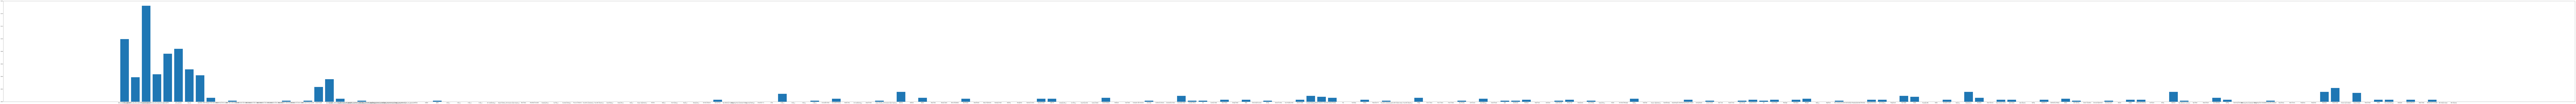

In [138]:
x = np.arange(len(X_train.columns.values))
fig, ax = plt.subplots(figsize=(500, 20))
plt.bar(x, height = xg_reg.feature_importances_) 
plt.xticks(x, X_train.columns.values)

## Training results

In [203]:
preds = [1 if x>0.50 else 0 for x in preds_p]

In [204]:
target_names = ['clk_diff_ref', 'clk_eq_ref']
print(classification_report(y_test, preds, target_names=target_names))

              precision    recall  f1-score   support

clk_diff_ref       0.97      0.99      0.98      1451
  clk_eq_ref       0.64      0.28      0.39        64

 avg / total       0.96      0.96      0.96      1515



In [205]:
accuracy = accuracy_score(y_test, preds)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 96.30%


## Dummy baseline (always say 0)

In [179]:
dummy = np.zeros(len(preds), dtype=np.int)

In [180]:
target_names = ['clk_diff_ref', 'clk_eq_ref']
print(classification_report(y_test, dummy, target_names=target_names))

              precision    recall  f1-score   support

clk_diff_ref       0.96      1.00      0.98      1451
  clk_eq_ref       0.00      0.00      0.00        64

 avg / total       0.92      0.96      0.94      1515



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [181]:
accuracy = accuracy_score(y_test, dummy)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 95.78%
